## Apply array of ML models to ROMs data


In [30]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

In [31]:
path = '/ospdat/nrosen/Data'

file_modern_ROMS_ctracers = path + '/ROMS/ds_ctracers_select.nc'
file_modern_ROMS_ntracers = path + '/ROMS/ds_ntracers_select.nc'

In [32]:
ds_ctracers = xr.open_dataset(file_modern_ROMS_ctracers)
ds_ntracers = xr.open_dataset(file_modern_ROMS_ntracers)
ds = ds_ctracers

#### Add dates to ROMS time dimension

In [33]:
def add_dates_ROMS(ds):
    ds = ds.set_coords(['lon_rho', 'lat_rho'])
    
    date1_m = "1994-01-01"
    date2_m = "2007-11-01"
    time_length_m = len(ds['ocean_time'])

    month_list_modern = [i.strftime("%B %Y") for i in pd.date_range(start=date1_m, end=date2_m, freq='MS')]
    pd_date_modern = pd.to_datetime(month_list_modern)

    ds = ds.assign_coords(time=("time", pd_date_modern))
    
    return(ds, month_list_modern)

In [34]:
ds_ctracers, month_list_modern = add_dates_ROMS(ds_ctracers)
ds_ntracers, month_list_modern = add_dates_ROMS(ds_ntracers)

In [35]:
ds_surf = ds.isel(depth=0)
ds_surf = ds_surf.assign_coords({'t':'time'})
ds_surf = ds_surf.swap_dims({'time':'t1'})
ds_surf = ds_surf.reset_coords(('lat_rho','lon_rho','time'))

pco2 = ds_surf.pco2

t,m,n = pco2.shape
npts = t*m*n

time = ds_surf.time
time = time.expand_dims(lat=m,lon=n,axis=(1,2))

lat = ds_surf.lat_rho
lat = lat.expand_dims(t=t,axis=0)

lon = ds_surf.lon_rho
lon = lon.expand_dims(t=t,axis=0)

df = pd.DataFrame()

df['time'] = time.to_numpy().reshape(npts)

df['lat'] = lat.to_numpy().reshape(npts)

df['lon'] = lon.to_numpy().reshape(npts)

df['SST'] = ds_surf.temp.to_numpy().reshape(npts)
df['SSS'] = ds_surf.salt.to_numpy().reshape(npts)
df['pco2'] = pco2.to_numpy().reshape(npts)
df['month'] = df.time.dt.month
df['year'] = df.time.dt.year

df.dropna(axis=0,inplace=True)

In [36]:
## import desired models
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

# Define the features (X) and target (y) variables
X = df[["lat", "lon", "SST", "SSS","month","year" ]]
y = df["pco2"]

# take only 10% of available data

X = X[::10]
y = y[::10]

# Use a MinMaxScaler to scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)


In [37]:
## run models
from tqdm import tqdm

models = [LinearRegression(),RandomForestRegressor(),MLPRegressor()]#,LogisticRegression()]

for m in tqdm(models):
    m.fit(X_train,y_train)


100%|██████████| 3/3 [1:21:32<00:00, 1630.86s/it]


In [38]:
names = ['Linear Regression','Random Forest','MLP']
r2 = []
for i,m in enumerate(models):
    yhat = m.predict(X_test)
    score = m.score(X_test, y_test)
    r2.append(score)
    #metrics = precision_recall_fscore_support(y_test, yhat, average='binary')
    #(precision, recall, F1) = (metrics[0], metrics[1], metrics[2])
    print(f'Model: {names[i]} R^2 score: {score}')

Model: Linear Regression R^2 score: 0.40297909162247114
Model: Random Forest R^2 score: 0.9811911896053032
Model: MLP R^2 score: 0.7422243579159644


In [39]:
y_pred = [m.predict(X_test) for m in models]

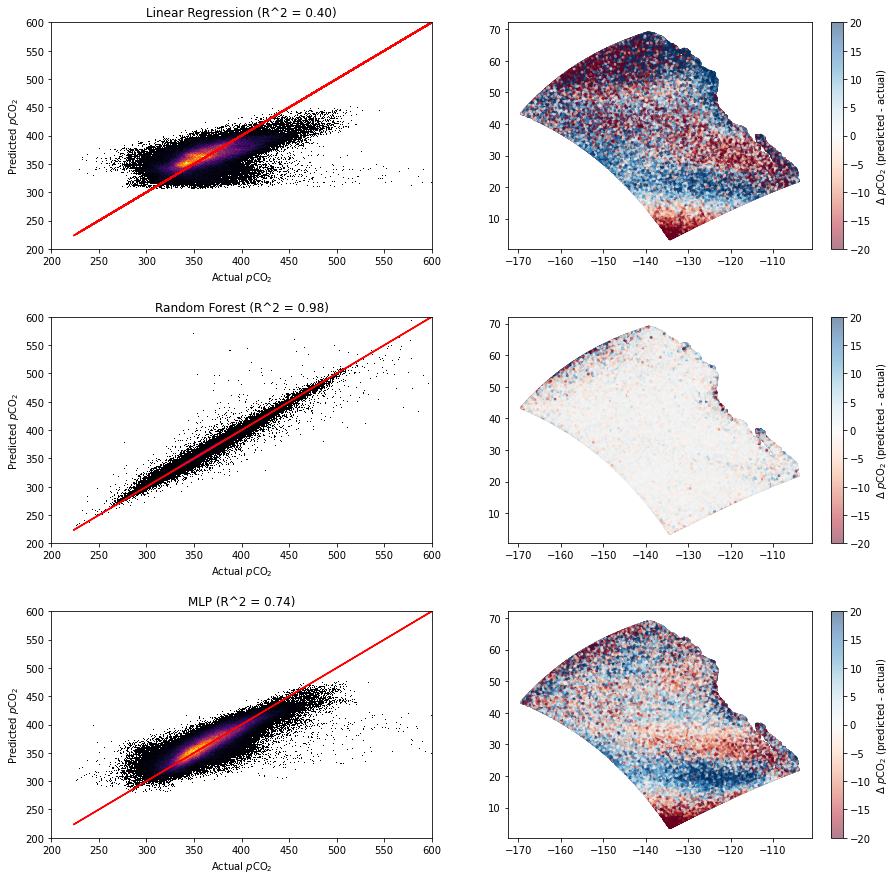

In [52]:
fig,axs = plt.subplots(ncols = 2,nrows=3,figsize=(15,15))
lon_plot,lat_plot = (X_test[:,1],X_test[:,0])

maxlat = ds.lat_rho.to_numpy().max()
minlat = ds.lat_rho.to_numpy().min()
maxlon = ds.lon_rho.to_numpy().max()
minlon = ds.lon_rho.to_numpy().min()

lat_scf = (maxlon-minlon)/(lat_plot.max()-lat_plot.min())

lat_plot = (lat_scf)*lat_plot
lat_plot = minlat + lat_plot



lon_plot = (maxlon-minlon)*lon_plot
lon_plot = minlon + lon_plot

norm = plt.Normalize(-20,20)

import seaborn as sns

for i in range(3):
    
    sns.histplot(x=y_test,y=y_pred[i],ax=axs[i,0],label=f'{names[i]} prediction',cmap='inferno')
    #axs[i,0].plot(y_test,y_pred[i],',',label =f'{names[i]} prediction')
    axs[i,0].plot(y_test,y_test,'-r')
    axs[i,0].set_xlabel(r'Actual $p$CO$_2$')
    axs[i,0].set_ylabel(r'Predicted $p$CO$_2$')
    axs[i,0].set_title(f'{names[i]} (R^2 = {r2[i]:.2f})')
   # axs[i,0].legend()
    axs[i,0].set_xlim(200,600)
    axs[i,0].set_ylim(200,600)
    
    diff = y_pred[i]-y_test
    im = axs[i,1].scatter(x=lon_plot,y=lat_plot,c=diff,s=4,norm=norm,cmap='RdBu',alpha=0.5)
    plt.colorbar(im,ax=axs[i,1],label=r'$\Delta$ $p$CO$_2$ (predicted - actual)')

plt.subplots_adjust(hspace=0.3)

Text(0, 0.5, 'Relative Importance')

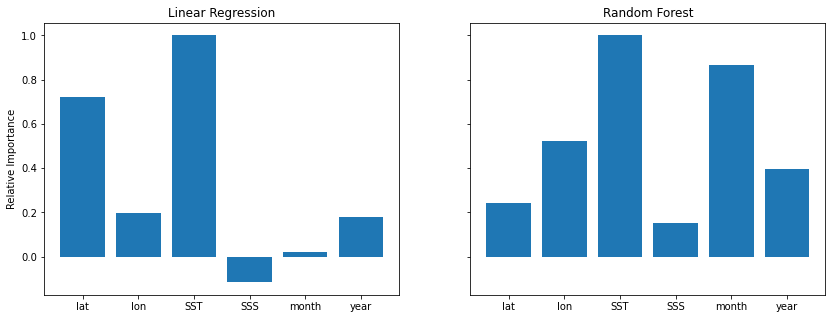

In [66]:
features = ["lat", "lon", "SST", "SSS","month","year" ]

fimportances = [models[0].coef_,models[1].feature_importances_]

fig,ax=plt.subplots(ncols=2,figsize=(14,5),sharey=True)
for i in range(2):
    
    ax[i].bar(features,fimportances[i]/fimportances[i].max())

    
    #pt.show()
    ax[i].set_title(names[i])
    
ax[0].set_ylabel('Relative Importance')